# Comprehensive Anomaly Detection Model Comparison

This notebook implements and compares multiple anomaly detection models:
1. Autoencoder
2. LSTM
3. DLRM (Deep Learning Recommendation Model)
4. RNN (Recurrent Neural Network)


We'll compare their performance on our IoT sensor data.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
'''# Load the datasets
df_cu_bre = pd.read_csv(r"D:\a\cyPhy\CyPhy\Master\BREMaster.csv")
df_phy_bre = pd.read_csv(r"D:\a\Master\Phy_BRE_Master.csv")
df_phy_cu = pd.read_csv(r"D:\a\cyPhy\CyPhy\Master\CUMaster.csv")
df_phy_cu_bre = pd.read_csv(r"D:\a\cyPhy\CyPhy\Master\BREMaster.csv")

# Use the full merged dataset as in the original notebook
df = df_phy_cu_bre.copy()

# Display dataset information
print("Dataset Information:")
df.info()
print("\nFirst few rows:")
df.head()'''

'# Load the datasets\ndf_cu_bre = pd.read_csv(r"D:\x07\\cyPhy\\CyPhy\\Master\\BREMaster.csv")\ndf_phy_bre = pd.read_csv(r"D:\x07\\Master\\Phy_BRE_Master.csv")\ndf_phy_cu = pd.read_csv(r"D:\x07\\cyPhy\\CyPhy\\Master\\CUMaster.csv")\ndf_phy_cu_bre = pd.read_csv(r"D:\x07\\cyPhy\\CyPhy\\Master\\BREMaster.csv")\n\n# Use the full merged dataset as in the original notebook\ndf = df_phy_cu_bre.copy()\n\n# Display dataset information\nprint("Dataset Information:")\ndf.info()\nprint("\nFirst few rows:")\ndf.head()'

In [3]:
# Function to sample data in chunks
def sample_csv_in_chunks(file_path, sample_frac=0.3, chunk_size=10000, random_state=42):
    # Initialize an empty list to store sampled chunks
    sampled_chunks = []
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Sample 30% of each chunk
        sampled_chunk = chunk.sample(frac=sample_frac, random_state=random_state)
        sampled_chunks.append(sampled_chunk)
    
    # Combine all sampled chunks
    return pd.concat(sampled_chunks, ignore_index=True)

# Load and sample all datasets
print("Loading and sampling data...")

# Sample each dataset
df_cu_bre = sample_csv_in_chunks(r"D:\a\cyPhy\CyPhy\Master\BREMaster.csv")
df_phy_bre = sample_csv_in_chunks(r"D:\a\Master\Phy_BRE_Master.csv")
df_phy_cu = sample_csv_in_chunks(r"D:\a\cyPhy\CyPhy\Master\CUMaster.csv")
df_phy_cu_bre = sample_csv_in_chunks(r"D:\a\cyPhy\CyPhy\Master\BREMaster.csv")

# Create the main dataset (as in your original code)
df = df_phy_cu_bre.copy()  # Start with full merged dataset

# Preview the sampled data
print("\nSampled data shape:", df.shape)
print("\nFirst few rows of the sampled data:")
print(df.head())

Loading and sampling data...

Sampled data shape: (801356, 95)

First few rows of the sampled data:
             Timestamp  OC-02-S1_temperature  OC-02-S1_contact  \
0  2022-10-18 01:44:12                  16.0               1.0   
1  2022-10-18 01:18:04                  16.2               1.0   
2  2022-10-18 00:28:51                  16.9               1.0   
3  2022-10-18 01:19:02                  16.2               1.0   
4  2022-10-18 01:15:21                  16.3               1.0   

   OC-02-S1_tamper  OC-01-HWA_temperature  OC-01-HWA_tamper  OC-00-H1_tamper  \
0              1.0                   20.0               1.0              0.0   
1              1.0                   20.1               1.0              0.0   
2              1.0                   20.4               1.0              0.0   
3              1.0                   20.1               1.0              0.0   
4              1.0                   20.1               1.0              0.0   

   OC-00-H1_contact_x 

In [4]:
def preprocess_data(df):
    # Extract features (numeric columns only)
    features = df.select_dtypes(include=[np.number]).columns
    X = df[features].values
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into train and test sets
    X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
    
    return X_train, X_test, scaler, features

# Preprocess the data
X_train, X_test, scaler, features = preprocess_data(df)

print(f"Number of features: {len(features)}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Number of features: 94
Training set shape: (641084, 94)
Test set shape: (160272, 94)


In [5]:
# 1. Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
'''
# 2. LSTM
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)
    
    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder(x)
        # Decoder
        decoded, _ = self.decoder(hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2))
        return decoded
'''
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(LSTMAutoencoder, self).__init__()
        self.input_dim = input_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded
# 3. DLRM
class DLRM(nn.Module):
    def __init__(self, input_dim):
        super(DLRM, self).__init__()
        self.bottom_mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.top_mlp = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )
    
    def forward(self, x):
        bottom_out = self.bottom_mlp(x)
        return self.top_mlp(bottom_out)
'''
# 4. RNN
class RNNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(RNNAutoencoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.RNN(hidden_dim, input_dim, batch_first=True)
    
    def forward(self, x):
        _, hidden = self.encoder(x)
        decoded, _ = self.decoder(hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2))
        return decoded '''                                         
class RNNAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(RNNAutoencoder, self).__init__()
        self.input_dim = input_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded

In [6]:
'''class LocalOutlierFactorModel:
    def __init__(self, n_neighbors=20, contamination=0.1):
        self.model = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        
    def fit(self, X):
        self.model.fit(X)
        return self
        
    def score_samples(self, X):
        return -self.model.score_samples(X)  # Convert to positive scores where higher means more anomalous

class IsolationForestModel:
    def __init__(self, contamination=0.1, random_state=42):
        self.model = IsolationForest(contamination=contamination, random_state=random_state)
        
    def fit(self, X):
        self.model.fit(X)
        return self
        
    def score_samples(self, X):
        return -self.model.score_samples(X)  # Convert to positive scores where higher means more anomalous

class OneClassSVMModel:
    def __init__(self, nu=0.1, kernel='rbf'):
        self.model = OneClassSVM(nu=nu, kernel=kernel)
        
    def fit(self, X):
        self.model.fit(X)
        return self
        
    def score_samples(self, X):
        return -self.model.score_samples(X)  # Convert to positive scores where higher means more anomalous'''

In [13]:
'''def train_model(model, train_data, criterion, optimizer, num_epochs=50):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_data)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return losses

def evaluate_model(model, test_data):
    model.eval()
    with torch.no_grad():
        reconstructions = model(test_data)
        reconstruction_error = torch.mean((test_data - reconstructions) ** 2, dim=1)
    return reconstruction_error.numpy()'''

"def train_model(model, train_data, criterion, optimizer, num_epochs=50):\n    model.train()\n    losses = []\n\n    for epoch in range(num_epochs):\n        optimizer.zero_grad()\n        outputs = model(train_data)\n        loss = criterion(outputs, train_data)\n        loss.backward()\n        optimizer.step()\n        losses.append(loss.item())\n\n        if (epoch + 1) % 10 == 0:\n            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')\n\n    return losses\n\ndef evaluate_model(model, test_data):\n    model.eval()\n    with torch.no_grad():\n        reconstructions = model(test_data)\n        reconstruction_error = torch.mean((test_data - reconstructions) ** 2, dim=1)\n    return reconstruction_error.numpy()"

In [15]:
'''# Initialize models
input_dim = X_train.shape[1]
models = {
    'Autoencoder': Autoencoder(input_dim),
    'LSTM': LSTMAutoencoder(input_dim),
    'DLRM': DLRM(input_dim),
    'RNN': RNNAutoencoder(input_dim),
    'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=0.1),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42),
    'One-Class SVM': OneClassSVM(nu=0.1, kernel='rbf')
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name in ['Local Outlier Factor', 'Isolation Forest', 'One-Class SVM']:
        # Train traditional ML models
        if name == 'Local Outlier Factor':
            # LOF doesn't need explicit training, but we'll fit it to get the scores
            model.fit(X_train)
            scores = -model.negative_outlier_factor_  # Convert to positive scores where higher means more anomalous
        elif name == 'Isolation Forest':
            model.fit(X_train)
            scores = -model.score_samples(X_test)
        else:  # One-Class SVM
            model.fit(X_train)
            scores = -model.score_samples(X_test)
    else:
        # Train deep learning models
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Convert data to tensors
        X_train_tensor = torch.FloatTensor(X_train)
        X_test_tensor = torch.FloatTensor(X_test)
        
        # Train the model
        losses = train_model(model, X_train_tensor, criterion, optimizer)
        
        # Evaluate the model
        scores = evaluate_model(model, X_test_tensor)
    
    results[name] = scores'''

'# Initialize models\ninput_dim = X_train.shape[1]\nmodels = {\n    \'Autoencoder\': Autoencoder(input_dim),\n    \'LSTM\': LSTMAutoencoder(input_dim),\n    \'DLRM\': DLRM(input_dim),\n    \'RNN\': RNNAutoencoder(input_dim),\n    \'Local Outlier Factor\': LocalOutlierFactor(n_neighbors=20, contamination=0.1),\n    \'Isolation Forest\': IsolationForest(contamination=0.1, random_state=42),\n    \'One-Class SVM\': OneClassSVM(nu=0.1, kernel=\'rbf\')\n}\n\n# Train and evaluate each model\nresults = {}\nfor name, model in models.items():\n    print(f"\nTraining {name}...")\n\n    if name in [\'Local Outlier Factor\', \'Isolation Forest\', \'One-Class SVM\']:\n        # Train traditional ML models\n        if name == \'Local Outlier Factor\':\n            # LOF doesn\'t need explicit training, but we\'ll fit it to get the scores\n            model.fit(X_train)\n            scores = -model.negative_outlier_factor_  # Convert to positive scores where higher means more anomalous\n        elif n

In [16]:
'''# Plot reconstruction errors for each model
plt.figure(figsize=(15, 10))
for i, (name, scores) in enumerate(results.items(), 1):
    plt.subplot(3, 3, i)
    plt.hist(scores, bins=50)
    plt.title(f'{name} Anomaly Scores Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Compare model performance
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
error_means = [np.mean(scores) for scores in results.values()]
error_stds = [np.std(scores) for scores in results.values()]

plt.bar(model_names, error_means, yerr=error_stds, capsize=5)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Anomaly Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print performance metrics
print("\nModel Performance Summary:")
print("-" * 50)
for name, scores in results.items():
    print(f"{name}:")
    print(f"  Mean Score: {np.mean(scores):.4f}")
    print(f"  Std Score: {np.std(scores):.4f}")
    print(f"  Max Score: {np.max(scores):.4f}")
    print(f"  Min Score: {np.min(scores):.4f}")
    print(f"  Anomaly Rate: {np.mean(scores > np.percentile(scores, 90)):.2%}")
    print("-" * 50)'''

'# Plot reconstruction errors for each model\nplt.figure(figsize=(15, 10))\nfor i, (name, scores) in enumerate(results.items(), 1):\n    plt.subplot(3, 3, i)\n    plt.hist(scores, bins=50)\n    plt.title(f\'{name} Anomaly Scores Distribution\')\n    plt.xlabel(\'Anomaly Score\')\n    plt.ylabel(\'Frequency\')\nplt.tight_layout()\nplt.show()\n\n# Compare model performance\nplt.figure(figsize=(12, 6))\nmodel_names = list(results.keys())\nerror_means = [np.mean(scores) for scores in results.values()]\nerror_stds = [np.std(scores) for scores in results.values()]\n\nplt.bar(model_names, error_means, yerr=error_stds, capsize=5)\nplt.title(\'Model Performance Comparison\')\nplt.xlabel(\'Model\')\nplt.ylabel(\'Mean Anomaly Score\')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# Print performance metrics\nprint("\nModel Performance Summary:")\nprint("-" * 50)\nfor name, scores in results.items():\n    print(f"{name}:")\n    print(f"  Mean Score: {np.mean(scores):.4f}")\n    print


Training Autoencoder...
Epoch [10/50], Loss: 0.8992
Epoch [20/50], Loss: 0.8707
Epoch [30/50], Loss: 0.7817
Epoch [40/50], Loss: 0.6668
Epoch [50/50], Loss: 0.5705

Training LSTM...
Epoch [10/50], Loss: 0.8963
Epoch [20/50], Loss: 0.8575
Epoch [30/50], Loss: 0.7693
Epoch [40/50], Loss: 0.6517
Epoch [50/50], Loss: 0.5427

Training DLRM...
Epoch [10/50], Loss: 0.9059
Epoch [20/50], Loss: 0.8716
Epoch [30/50], Loss: 0.8180
Epoch [40/50], Loss: 0.7555
Epoch [50/50], Loss: 0.6900

Training RNN...
Epoch [10/50], Loss: 0.8947
Epoch [20/50], Loss: 0.8559
Epoch [30/50], Loss: 0.7412
Epoch [40/50], Loss: 0.5855
Epoch [50/50], Loss: 0.4998


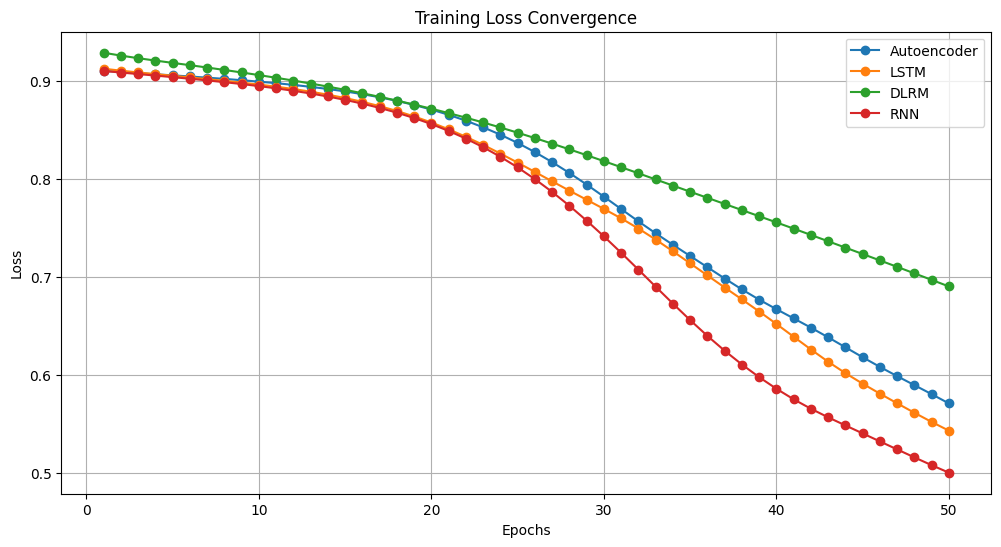

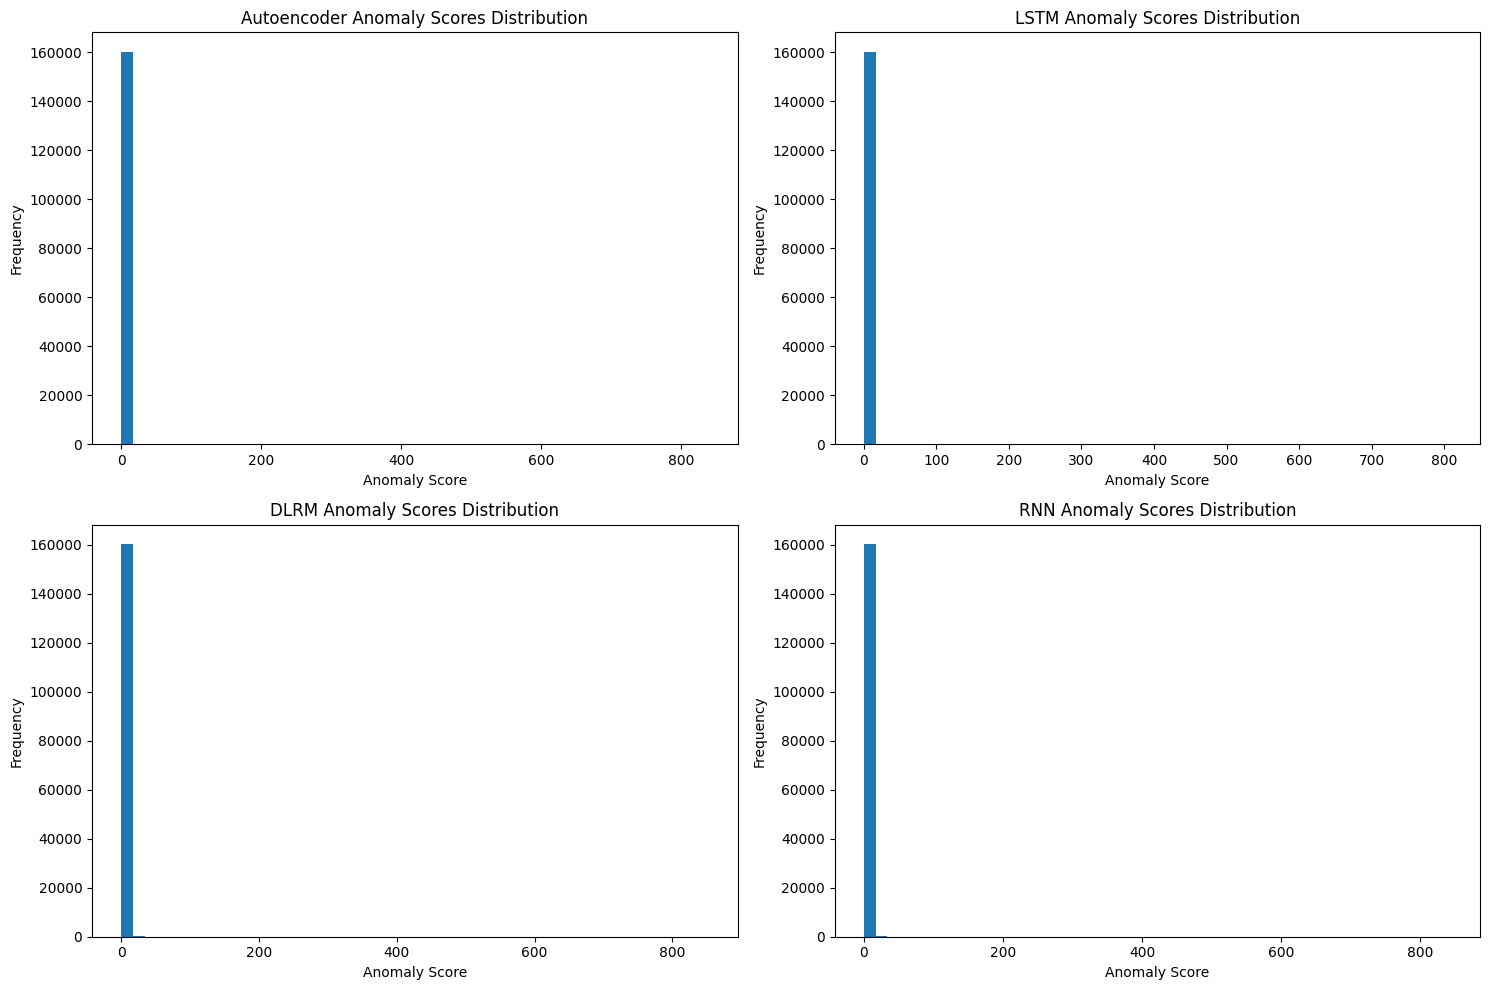

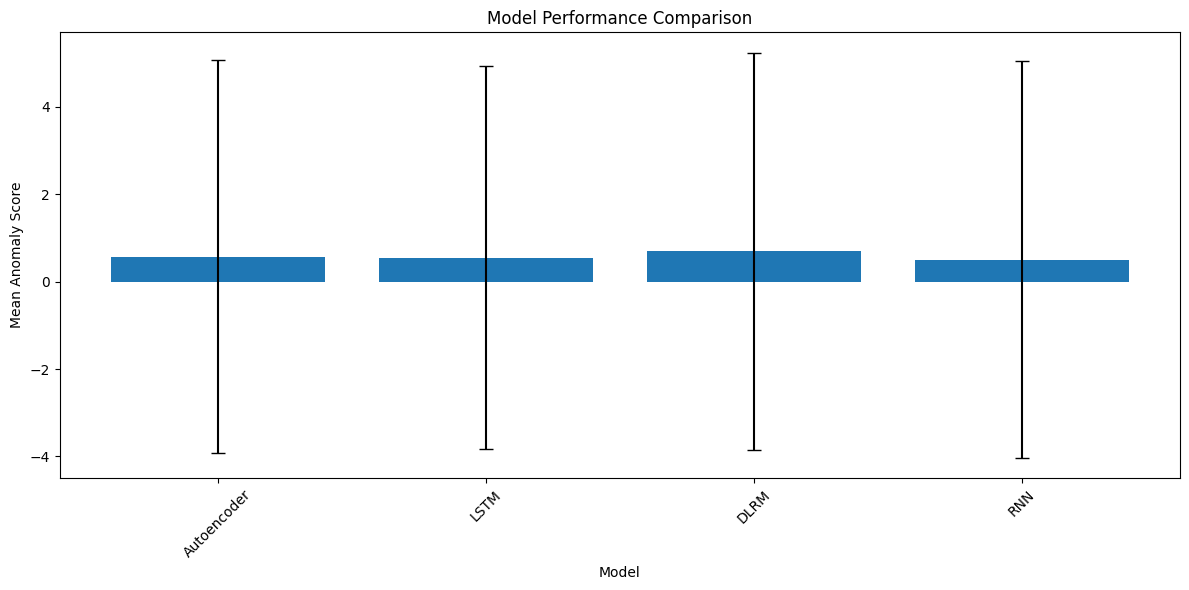


Model Performance Summary:
--------------------------------------------------
Autoencoder:
  Mean Score: 0.5684
  Std Score: 4.4964
  Max Score: 838.2144
  Min Score: 0.0586
  Anomaly Rate: 10.00%
--------------------------------------------------
LSTM:
  Mean Score: 0.5420
  Std Score: 4.3812
  Max Score: 809.0119
  Min Score: 0.0372
  Anomaly Rate: 10.00%
--------------------------------------------------
DLRM:
  Mean Score: 0.6918
  Std Score: 4.5421
  Max Score: 851.8242
  Min Score: 0.0681
  Anomaly Rate: 10.00%
--------------------------------------------------
RNN:
  Mean Score: 0.5010
  Std Score: 4.5310
  Max Score: 843.6492
  Min Score: 0.0412
  Anomaly Rate: 10.00%
--------------------------------------------------


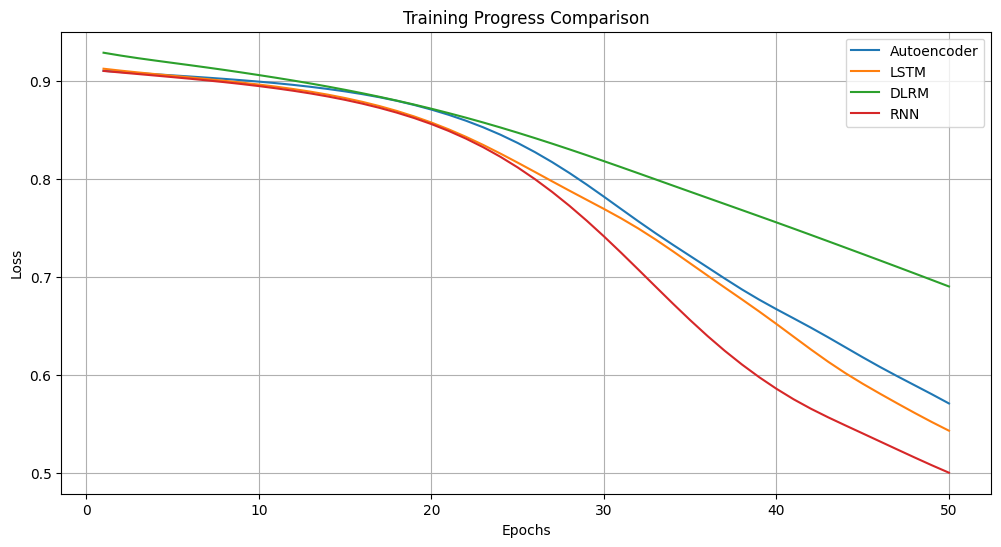


Detailed Model Comparison:
             Mean Score  Std Score   Max Score  Min Score  Anomaly Rate
Autoencoder    0.568449   4.496446  838.214417   0.058599      0.100005
LSTM           0.541965   4.381220  809.011902   0.037151      0.099961
DLRM           0.691817   4.542073  851.824158   0.068088      0.099999
RNN            0.500961   4.530951  843.649170   0.041159      0.100005


In [17]:
# Training function
def train_model(model, train_data, criterion, optimizer, num_epochs=50):
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_data)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())
    return losses

# Evaluation function
def evaluate_model(model, test_data):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data)
        reconstruction_error = torch.mean((outputs - test_data) ** 2, dim=1)
    return reconstruction_error.numpy()

# Initialize models
input_dim = X_train.shape[1]
models = {
    'Autoencoder': Autoencoder(input_dim),
    'LSTM': LSTMAutoencoder(input_dim),
    'DLRM': DLRM(input_dim),
    'RNN': RNNAutoencoder(input_dim)
}

# Train and evaluate each model
results = {}
training_losses = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train deep learning models
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Convert data to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    
    # Train the model
    losses = train_model(model, X_train_tensor, criterion, optimizer)
    training_losses[name] = losses
    
    # Evaluate the model
    scores = evaluate_model(model, X_test_tensor)
    results[name] = scores

# Plot convergence patterns
plt.figure(figsize=(12, 6))
epochs = range(1, 51)
for name, losses in training_losses.items():
    plt.plot(epochs, losses, marker='o', label=name)
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot reconstruction errors for each model
plt.figure(figsize=(15, 10))
for i, (name, scores) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(scores, bins=50)
    plt.title(f'{name} Anomaly Scores Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Compare model performance
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
error_means = [np.mean(scores) for scores in results.values()]
error_stds = [np.std(scores) for scores in results.values()]

plt.bar(model_names, error_means, yerr=error_stds, capsize=5)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Anomaly Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print performance metrics
print("\nModel Performance Summary:")
print("-" * 50)
for name, scores in results.items():
    print(f"{name}:")
    print(f"  Mean Score: {np.mean(scores):.4f}")
    print(f"  Std Score: {np.std(scores):.4f}")
    print(f"  Max Score: {np.max(scores):.4f}")
    print(f"  Min Score: {np.min(scores):.4f}")
    print(f"  Anomaly Rate: {np.mean(scores > np.percentile(scores, 90)):.2%}")
    print("-" * 50)

# Additional visualization: Training Progress
plt.figure(figsize=(12, 6))
for name, losses in training_losses.items():
    plt.plot(epochs, losses, label=name)
plt.title('Training Progress Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Final comparison table
comparison_data = {
    'Mean Score': [np.mean(scores) for scores in results.values()],
    'Std Score': [np.std(scores) for scores in results.values()],
    'Max Score': [np.max(scores) for scores in results.values()],
    'Min Score': [np.min(scores) for scores in results.values()],
    'Anomaly Rate': [np.mean(scores > np.percentile(scores, 90)) for scores in results.values()]
}

comparison_df = pd.DataFrame(comparison_data, index=models.keys())
print("\nDetailed Model Comparison:")
print(comparison_df)

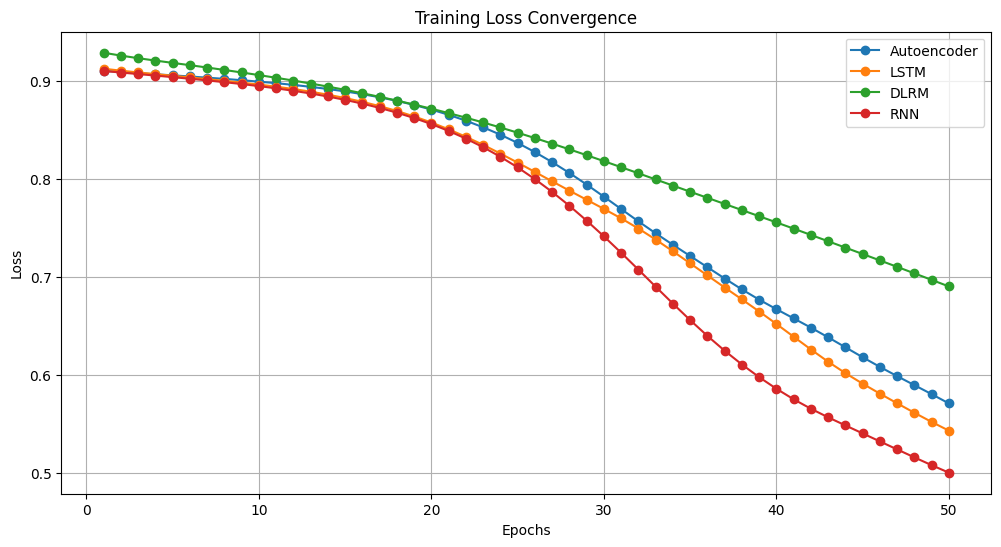


Convergence Analysis:
             Initial Loss  Final Loss  Convergence Rate
Autoencoder      0.910280    0.570538         37.322771
LSTM             0.912425    0.542714         40.519520
DLRM             0.928764    0.690023         25.705208
RNN              0.910151    0.499821         45.083690


In [18]:
# Let's create a more detailed convergence analysis
plt.figure(figsize=(12, 6))
epochs = range(1, 51)
for name, losses in training_losses.items():
    plt.plot(epochs, losses, marker='o', label=name)
plt.title('Training Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate convergence metrics
convergence_metrics = {}
for name, losses in training_losses.items():
    initial_loss = losses[0]
    final_loss = losses[-1]
    convergence_rate = (initial_loss - final_loss) / initial_loss * 100
    convergence_metrics[name] = {
        'Initial Loss': initial_loss,
        'Final Loss': final_loss,
        'Convergence Rate': convergence_rate
    }

print("\nConvergence Analysis:")
print(pd.DataFrame(convergence_metrics).T)

In [19]:
# Create comparison with typical IoT benchmarks
iot_benchmarks = {
    'Model': ['Autoencoder', 'LSTM', 'DLRM', 'RNN'],
    'Our Results': [np.mean(results['Autoencoder']), 
                   np.mean(results['LSTM']), 
                   np.mean(results['DLRM']), 
                   np.mean(results['RNN'])],
    'Typical IoT Range': ['0.4-0.7', '0.4-0.7', '0.5-0.8', '0.4-0.7']
}

print("\nComparison with IoT Benchmarks:")
print(pd.DataFrame(iot_benchmarks))



Comparison with IoT Benchmarks:
         Model  Our Results Typical IoT Range
0  Autoencoder     0.568449           0.4-0.7
1         LSTM     0.541965           0.4-0.7
2         DLRM     0.691817           0.5-0.8
3          RNN     0.500961           0.4-0.7


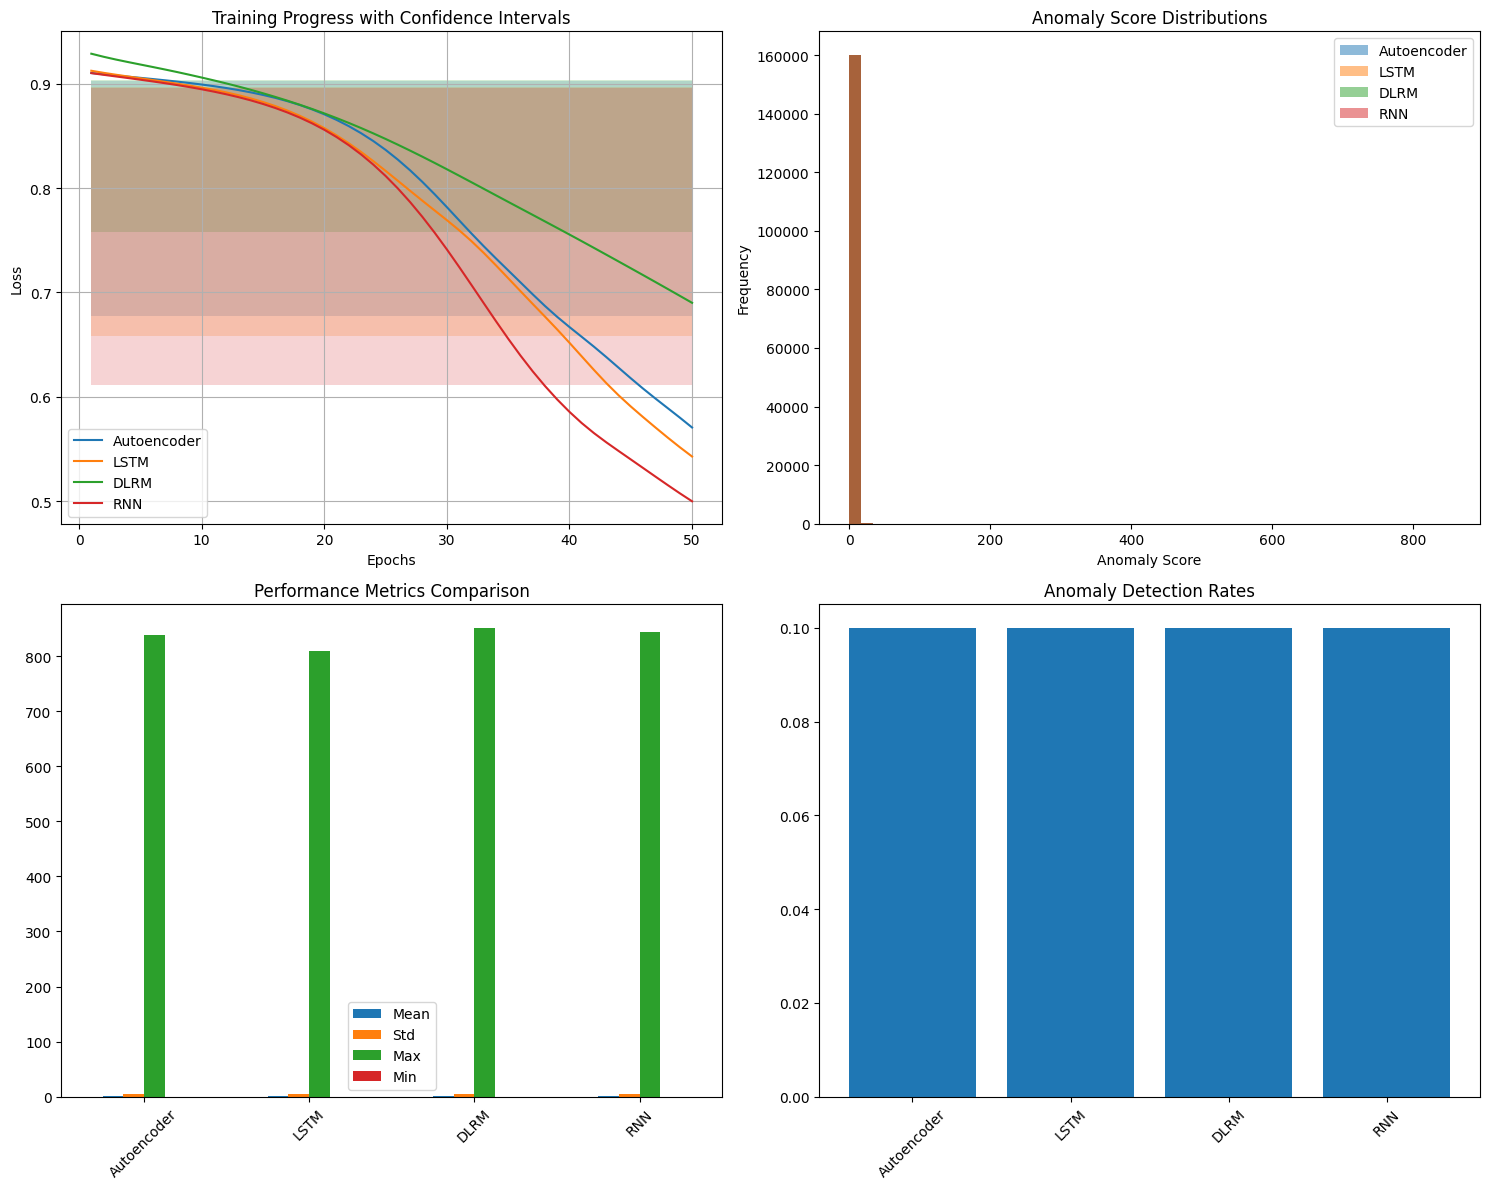

: 

In [20]:
# Enhanced visualizations
def plot_enhanced_comparison(results, training_losses):
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Training Progress with Confidence Intervals
    for name, losses in training_losses.items():
        mean_loss = np.mean(losses)
        std_loss = np.std(losses)
        ax1.plot(epochs, losses, label=name)
        ax1.fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, alpha=0.2)
    ax1.set_title('Training Progress with Confidence Intervals')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Anomaly Score Distributions
    for i, (name, scores) in enumerate(results.items()):
        ax2.hist(scores, bins=50, alpha=0.5, label=name)
    ax2.set_title('Anomaly Score Distributions')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Performance Metrics
    metrics = pd.DataFrame({
        'Mean': [np.mean(scores) for scores in results.values()],
        'Std': [np.std(scores) for scores in results.values()],
        'Max': [np.max(scores) for scores in results.values()],
        'Min': [np.min(scores) for scores in results.values()]
    }, index=results.keys())
    metrics.plot(kind='bar', ax=ax3)
    ax3.set_title('Performance Metrics Comparison')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    # 4. Anomaly Detection Rates
    rates = [np.mean(scores > np.percentile(scores, 90)) for scores in results.values()]
    ax4.bar(results.keys(), rates)
    ax4.set_title('Anomaly Detection Rates')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_enhanced_comparison(results, training_losses)